In [1]:
%cd /content/drive/MyDrive/Outlier_detection/

/content/drive/MyDrive/Outlier_detection


In [ ]:
!pip install alibi_detect

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
TRAIN_IMG_PATH = './None'

In [4]:
TRAIN_IMG_SIZE = (64, 64)
BATCH_SIZE = 32
image_gen = ImageDataGenerator(rescale=1./255) # image scaling
train_data = image_gen.flow_from_directory(directory=TRAIN_IMG_PATH, batch_size=BATCH_SIZE, shuffle=True, target_size=(64,64), class_mode=None)

Found 10000 images belonging to 1 classes.


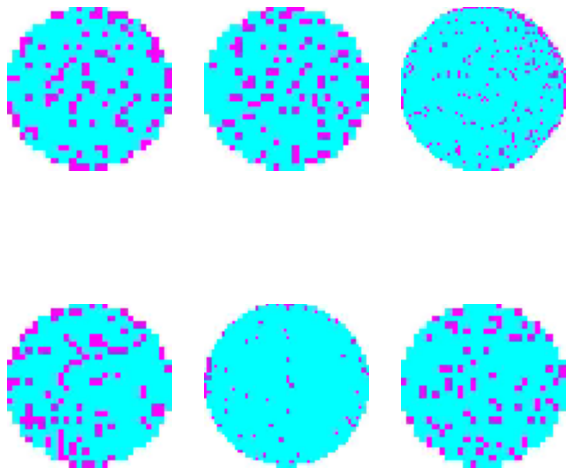

In [5]:
plt.figure(figsize=(10, 10))
img = train_data.next()
for i in range(6):
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(img[i])
  plt.axis("off")


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

In [7]:
latent_dim = 1024

encoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(64, 64, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

decoder_net = tf.keras.Sequential([
    InputLayer(input_shape=(latent_dim,)),
    Dense(4 * 4 * 128),
    Reshape(target_shape=(4, 4, 128)),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
])

od = OutlierVAE(
    threshold=.005,
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

In [10]:
for i in range(len(train_data)):
  img = train_data.next()
  od.fit(img, verbose=True)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [=] - 0s 77ms/step - loss: -17996.5098


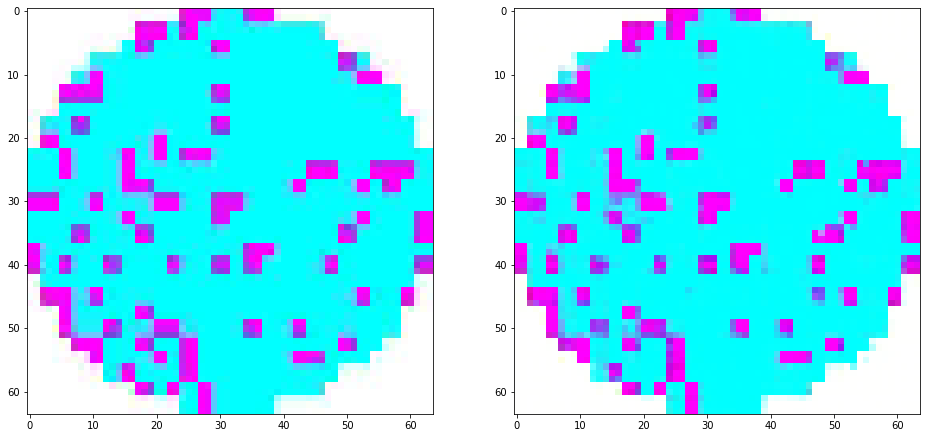

In [11]:
img = train_data.next()
x = img[0].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

In [12]:
TEST_IMG_PATH = './Non-normal'
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
image_gen = ImageDataGenerator(rescale=1./255) # image scaling
test_data = image_gen.flow_from_directory(directory=TEST_IMG_PATH, batch_size=BATCH_SIZE, shuffle=True, target_size=(64,64), class_mode=None)

Found 3272 images belonging to 8 classes.


In [13]:
test_img = test_data.next()

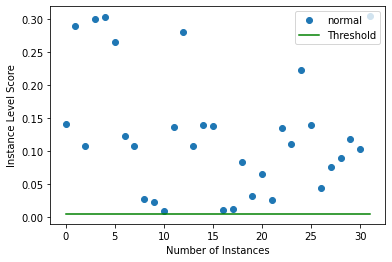

In [14]:
od_preds = od.predict(
    test_img,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(test_img.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

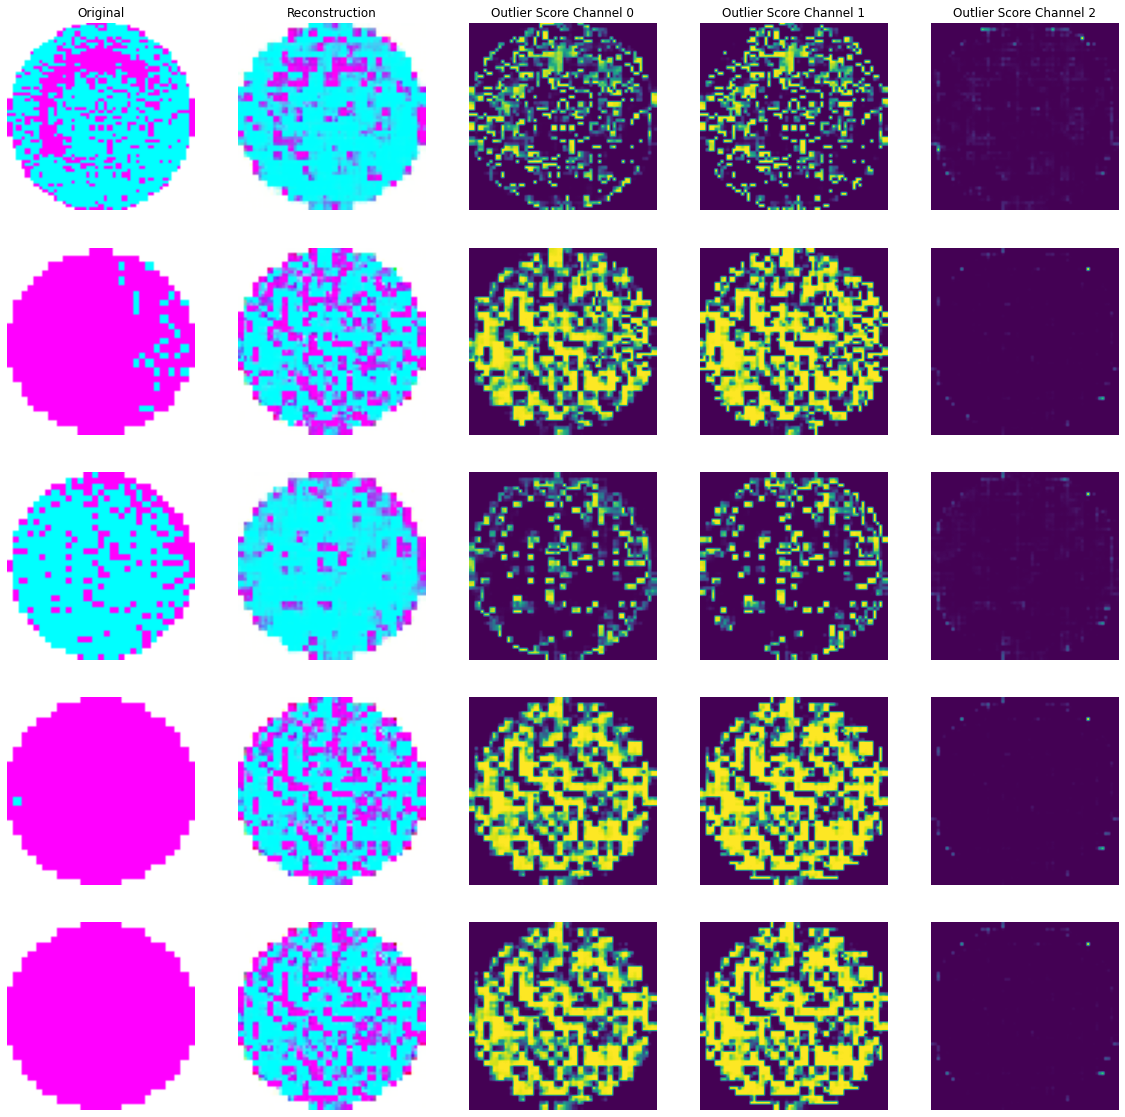

In [15]:
x_recon = od.vae(test_img).numpy()

plot_feature_outlier_image(
    od_preds,
    test_img,
    X_recon=x_recon,
    max_instances=5,
    outliers_only=False
)